# Sentiment Classification of Financial Texts using Neural Networks

Sentimentß classification stands as a pivotal task within the field of natural language processing (NLP), offering significant utility across various applications. This experiment focuses on crafting a straightforward neural network model aimed at categorizing sentences into predefined sentiment categories: positive, neutral, or negative.

The task at hand involves implementing a basic neural network architecture for the purpose of sentiment classification. This model endeavors to systematically assign financial sentences to one of the three sentiment classes mentioned. The dataset employed for training and evaluation originates from [Kaggle](https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis) and encompasses approximately 5,000 financial sentences. This dataset serves as the foundation for our experiment, providing a small(ish) range of sentences for model training and validation.

Our objective is to explore the efficacy of simple network structures in accurately classifying sentiment within the domain of financial texts. Through this exercise, we aim to gain insights into the challenges and potential of using neural networks for sentiment analysis in financial contexts.

We start by loading the data into separate sentences and sentiments. The original data is a simple CSV in the form:

```
sentence A,sentiment A
sentence B,sentiment B
...
```

## Pre-processing

In the pre-processing phase, we will simply load our CSV dataset into a list of entries, composed of sentences and sentiments.

In [1]:
import csv
import re
import datetime
import numpy as np

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def read_csv_data(file_path):
    # Create an empty list to store the data
    data = []

    # Open the CSV file
    with open(file_path, 'r') as file:
        # Create a CSV reader object
        reader = csv.reader(file)
        
        # Skip the header row if it exists
        next(reader)
        
        # Iterate over each row in the CSV file
        for row in reader:
            # Extract the sentence and sentiment from the row
            sentence = row[0]
            sentiment = row[1]
            
            # Create a dictionary to store the sentence and sentiment
            entry = {'sentence': sentence, 'sentiment': sentiment}
            
            # Append the entry to the data list
            data.append(entry)

    # Return the data list
    return data

## Importing the data

At this stage, we're prepared to load the data into appropriate data structures. It's important to note the conversion of sentiment labels from strings to numerical values, ranging from 0 (negative) to 2 (positive). Additionally, it's necessary to explicitly convert the list of sentiments into a NumPy array for further processing.

In [2]:

# Import data
data = read_csv_data('.data/data.csv')

# Prepare the dataset
sentences = [d['sentence'] for d in data]
sentiments = [2 if d['sentiment'] == 'positive' else (1 if d['sentiment'] == 'neutral' else 0) for d in data]
# Convert the sentiments list to a NumPy array as this is the format Keras requires
sentiments = np.array(sentiments)


FileNotFoundError: [Errno 2] No such file or directory: 'data.csv'

`sentences` is just a list (as a Numpy array) as such:

In [ ]:
print(sentences[0:2])

["The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and powerful commercial model .", '$ESI on lows, down $1.50 to $2.50 BK a real possibility']


In our case, the sentiments variable, which we convert into a NumPy array, comprises a list of integers where the value 2 represents positive, 1 denotes neutral, and 0 signifies negative sentiment. This numerical encoding, utilizing only non-negative integers, is essential for compatibility with the `sparse_categorical_crossentropy` loss function. This particular loss function mandates the use of non-negative integers, as it relies on these values to interpret the class labels correctly for model training.

In [ ]:
print(sentiments[0:2])

[2 0]


## Tokenizing content

In our preprocessing steps, we will tokenize the input sentences, constraining them to a vocabulary size of 5000 words. This limitation is intentionally set to foster a compact word space, which is important to aid the neural network's ability to generalize more effectively across unseen data. A smaller vocabulary size is an important choice to mitigate the risk of overfitting, as it encourages the model to focus on the most relevant features that are truly indicative of the sentiments expressed in the sentences, rather than memorizing specific, less frequent terms that may not contribute to a robust understanding of the text.

We also set a "Out of Vocabulary" token, meaning that the model will replace any words not in the vocabulary with this token. This is a crucial step to ensure that the model can handle unseen words during inference, preventing it from becoming confused or making incorrect predictions when encountering previously unseen terms. We will also filter out any punctuation marks and other characters from the sentences, as they are not typically indicative of sentiment and could introduce noise into the model's learning process.

Additionally, we will ensure that all tokenized sequences are padded to a uniform length of 50 tokens. This standardization is crucial for maintaining consistent input dimensions required by neural networks, facilitating batch processing and ensuring that the model can efficiently learn from sequences of a standardized shape. The choice of 50 tokens as the maximum sequence length is a balance between retaining sufficient contextual information and maintaining computational efficiency, preventing the model from becoming bogged down by excessively long inputs that could dilute meaningful signals with noise.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the dataset
max_words = 5000
max_len = 50
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>', lower=True, filters='!"#&()*+,-./:;<=>?@[\\]\'^_`{|}~\t\n')
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
padded_sequences = pad_sequences(sequences, padding='post', truncating='post', maxlen=max_len)

And let us look at what the tokenized sentences look like.

In [ ]:
# Print the first sentence and its padded sequence
print(sentences[0])
print(padded_sequences[0])
print(tokenizer.sequences_to_texts([padded_sequences[0]]))
print(type(padded_sequences), padded_sequences.shape)
print(type(sentiments), len(sentiments))


The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and powerful commercial model .
[   2 3968  135   14 3127 1407   10 2277  134   19  823 1221  101 2278
  135    7 3128 1222 1221 2010 3129  682    6    7   59    6 3969  581
  473    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
['the geosolutions technology will leverage benefon s gps solutions by providing location based search technology a communities platform location relevant multimedia content and a new and powerful commercial model <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']
<class 'numpy.ndarray'> (5842, 50)
<class 'numpy.ndarray'> 5842


## Splitting the dataset into training and validation

Splitting a dataset into training and validation subsets is a standard practice in machine learning and deep learning projects. This approach allows for the evaluation of model performance on unseen data, providing insights into how well the model is likely to perform on real-world data or under general conditions.

In our specific scenario, we have decided to allocate 20% of our dataset for validation purposes. This means that 80% of the data will be utilized for training the model, enabling it to learn and adapt to the patterns present in the data. The remaining 20% will serve as the validation set, which will not be used during the training process. Instead, it will be used to evaluate the model's performance, helping us to monitor and fine-tune the model's parameters and architecture to prevent overfitting and underfitting, ensuring that the model generalizes well to new, unseen data.

By employing this split, we can achieve a balance between having enough data for the model to learn effectively and retaining a sufficient amount of data to reliably assess its performance. This strategy is essential for developing robust models that perform well in practical applications.

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
training_sentences, validation_sentences, training_sentiments, validation_sentiments = train_test_split(padded_sequences, sentiments, test_size=0.2, random_state=42)

print("Training dataset:", "sentences -", training_sentences.shape, "sentiments -", training_sentiments.shape)
print("Validation dataset:", "sentences -", validation_sentences.shape, "sentiments -", validation_sentiments.shape)


Training dataset: sentences - (4673, 50) sentiments - (4673,)
Validation dataset: sentences - (1169, 50) sentiments - (1169,)


## Defining the classification model

We can now go about building the model for classification. We separate model parameters into `batch_size` and `embedding_dim` - this allows us to perform multiple comparative runs with different model parameters, which are then logged under TensorBoard for evaluation.

Assuming you have installed TensorBoard with `pip install tensorboard`, you can visualise results by running the command `tensorboard --logdir logs/model-nn` and loading `https://localhost:6006`.

We also configure early stopping of the training once loss and training accuracy level off.

<div class="alert alert-block alert-info">
<b>Note: </b>
Batch size can have a significant impact on the training process.

Smaller batch sizes:

- Faster Convergence: Smaller batches often lead to faster convergence because the model's weights are updated more frequently. However, these updates are noisier, which can be beneficial as it might help the model escape local minima.
- Regularization Effect: The noise introduced by smaller batches can also serve as a form of regularization, potentially improving generalization and thus accuracy on unseen data.
- Memory Efficiency: Smaller batches are more memory-efficient, enabling training on limited resources without compromising the ability to model complex relationships.
- Potential for Overfitting: While the regularization effect can improve generalization, there’s also a risk of overfitting if the batch size is too small, especially if not complemented with proper regularization techniques.

Larger batch sizes:

- Stable Gradient Estimates: Larger batches provide more stable estimates of the gradient, which can lead to smoother convergence. However, this stability may also lead the model to settle in sharp minima, which could generalize poorly.
- Reduced Regularization Effect: The reduced noise in the gradient estimates diminishes the implicit regularization effect seen with smaller batches, potentially necessitating explicit regularization methods.
- Higher Memory Requirements: Larger batch sizes require more memory, which can limit model complexity or batch size on hardware with limited resources.
- Efficiency and Speed: Training with larger batches can be more computationally efficient due to better utilization of hardware resources, such as GPUs, potentially reducing the time per epoch.
</div>


In [ ]:
# Build a classification model using a neural network

# Define identifiable information
model_name = 'model-nn'
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
batch_size = 16
embedding_dim = 4

# Create the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Embedding(max_words, embedding_dim, input_shape=(max_len,)),
    GlobalAveragePooling1D(),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

# Define a lower learning rate
learning_rate = 0.001

# Create an Adam optimizer with the desired learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

/Users/NLeitao/.pyenv/versions/3.9.18/envs/ml-env/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-03-26 04:58:37.409515: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-03-26 04:58:37.409534: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-26 04:58:37.409537: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-26 04:58:37.409553: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-26 04:58:37.409564: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow d

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 4)          │        20,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 4)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,015 (78.18 KB)

 Trainable params: 20,015 (78.18 KB)

 Non-trainable params: 0 (0.00 B)

## Understanding the model layers

This model is a simple neural network designed for text processing, utilizing an embedding layer at the beginning followed by dropout, pooling, and dense layers. Let's break down each layer and its purpose:

- **`Embedding` Layer**: This is the first layer of the model, which turns positive integers (indexes) into dense vectors of fixed size, `embedding_dim`. The `max_words` parameter defines the size of the vocabulary in the text data, and `max_len` specifies the length of input sequences. The embedding layer is crucial for text processing as it learns to represent words in a high-dimensional space in a way that captures semantic relationships between them.

- **`GlobalAveragePooling1D` Layer**: This layer reduces the dimensionality of the input by computing the mean of all the dimensions for each sample. It's useful for reducing the computational cost and simplifying the model while retaining important information. In the context of text, it helps to summarize the essential features of the embeddings across the sequence.

- **`Dropout` Layer**: This layer randomly sets input units to 0 with a frequency of 0.2 at each step during training time, which helps prevent overfitting. It's a form of regularization that forces the model to learn more robust features that are useful in conjunction with many different random subsets of the other neurons.

- **`Dense` Layer**: This is the output layer of the model, with 3 units and a softmax activation function, indicating that the model is designed for a classification task with 3 classes. The softmax function ensures that the output values are in the range (0, 1) and sum up to 1, making them interpretable as class probabilities.

### Model Compilation 

- The model is compiled with the `adam` optimizer, which is an adaptive learning rate optimization algorithm designed for training deep neural networks.
- The `sparse_categorical_crossentropy` loss function is used, suitable for multi-class classification tasks where the labels are integers (a common scenario in classification problems).
- The metric used to evaluate the model is accuracy, which is typical for classification tasks.

## Training the model

Finally we run and train the model.

In [ ]:
# Create a log directory with the identifiable information
log_dir = f"logs/{model_name}/batchsize{batch_size}_{timestamp}_maxwords{max_words}_embedding{embedding_dim}"

# Set up the TensorBoard callback
from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(training_sentences, training_sentiments,
                    batch_size=batch_size,
                    epochs=200,
                    validation_data=(validation_sentences, validation_sentiments),
                    verbose=0, # Set to 1 to print the training log
                    callbacks=[tensorboard_callback,early_stopping_callback])

# Print training statistics
print("Training accuracy:", history.history['accuracy'][-1])
print("Validation accuracy:", history.history['val_accuracy'][-1])

2024-03-26 04:58:37.643356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Training accuracy: 0.8469933867454529
Validation accuracy: 0.7134302854537964


## Plotting and visualizing the training history

At this stage, we can visualize the progression of our model's training through the lenses of accuracy and loss metrics. These two indicators provide essential insights into how well our model is performing and learning over time.

**Accuracy** is a measure of how often the model's predictions match the true labels of the data. It's a direct indicator of the model's performance, with higher values indicating better performance. In the context of training and validation, we typically observe two accuracy trends: one for the training set (showing how well the model fits the data it learns from) and one for the validation set (indicating how well the model generalizes to new, unseen data). An ideal model demonstrates high accuracy on both training and validation sets, suggesting it has learned well and can generalize its learning effectively.

**Loss**, on the other hand, quantifies the difference between the model's predicted values and the actual values for a given number of instances. It is a critical measure used during the training process to adjust the model's weights with the objective of minimizing this difference, hence improving the model's predictions. Like accuracy, we monitor loss for both training and validation datasets. A decreasing trend in loss over epochs signifies that the model is learning correctly. However, if validation loss starts to increase while training loss continues to decrease, it could indicate overfitting—meaning the model is performing well on the training data but poorly on new, unseen data.

Visualizing accuracy and loss during training provides valuable feedback on the learning process. It helps identify when the model has started to overfit, underfit, or if it's learning as expected. These insights guide adjustments to the model architecture, the training process, or even to the data itself, with the goal of achieving a well-performing model that generalizes well to new data.

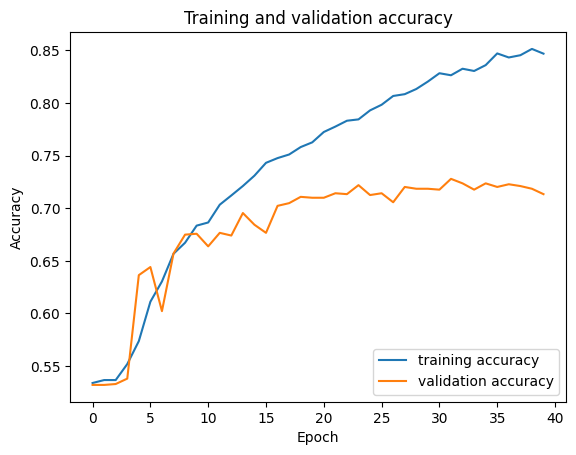

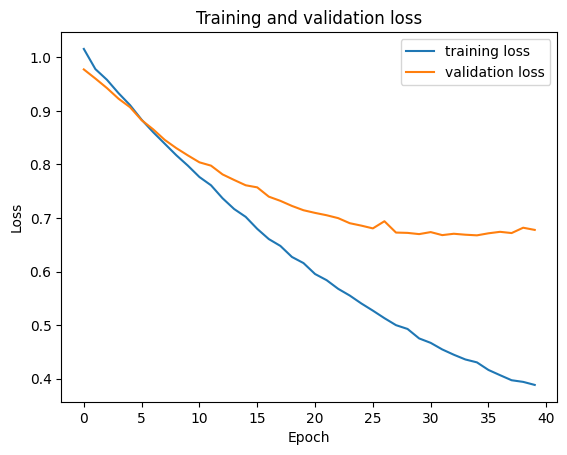

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

We can now try out some predictions on the model to see how it performs on unseen data.

In [ ]:
# Try a few predictions

# Define a function to predict the sentiment of a sentence
def predict_sentiment(sentence):
    # Tokenize the sentence
    sequence = tokenizer.texts_to_sequences([sentence])
    
    # Pad the sequence
    padded_sequence = pad_sequences(sequence, padding='post', truncating='post', maxlen=max_len)
    
    # Get the prediction
    prediction = model.predict(padded_sequence)[0]
    
    # Get the sentiment with the highest probability
    sentiment = np.argmax(prediction)
    
    return sentiment, prediction

# Predict the sentiment of a positive sentence
sentence = "IBM reported an increase in revenue during the last quarter"
sentiment, predictions = predict_sentiment(sentence)
print(f"Sentence: {sentence}, Predictions: {predictions}")
# Print the sentiment
if sentiment == 2:
    print("Correctly predicted - Sentiment: Positive")

# Predict the sentiment of a neutral sentence
sentence = "IBM is a technology company"
sentiment, predictions = predict_sentiment(sentence)
print(f"Sentence: {sentence}, Predictions: {predictions}")
if sentiment == 1:
    print("Correctly predicted - Sentiment: Neutral")

# Predict the sentiment of a negative sentence
sentence = "IBM down $3.4 in yesterday's trading session"
sentiment, predictions = predict_sentiment(sentence)
print(f"Sentence: {sentence}, Predictions: {predictions}")
if sentiment == 0:
    print("Correctly predicted - Sentiment: Negative")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Sentence: IBM reported an increase in revenue during the last quarter, Predictions: [0.10788833 0.1402162  0.7518954 ]
Correctly predicted - Sentiment: Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Sentence: IBM is a technology company, Predictions: [0.16141902 0.6629018  0.17567916]
Correctly predicted - Sentiment: Neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Sentence: IBM down $3.4 in yesterday's trading session, Predictions: [0.36254707 0.35306135 0.28439155]
Correctly predicted - Sentiment: Negative


In the above output, we can see the model's predictions for a few sample sentences. The model assigns a sentiment label to each sentence, with the corresponding probabilities for each class. The sentiment label with the highest probability is considered the model's prediction for that sentence. Keep in mind the index mapping for sentiment labels: 0 for negative, 1 for neutral, and 2 for positive. In the first sentence example, the model predicts `[0.10788833 0.1402162  0.7518954]`, or an 77% probability for a positive sentiment.

<div class="alert alert-block alert-warning">
<b>Warning: </b>
An important aspect of developing any model, is understanding your training data and the context in which the model will be used. In this case, the financial sentiment dataset is relatively small and will not be representative enough. You should also consider the potential biases in the data and how they might impact the model's predictions, for example, in our dataset we have an uneven distribution of sentiment classes:

```bash
grep ",negative" $HOME/Downloads/data.csv|wc -l
     860
grep ",neutral" $HOME/Downloads/data.csv|wc -l
    3130
grep ",positive" $HOME/Downloads/data.csv|wc -l
    1852
```

It's important to keep these limitations in mind when interpreting the model's predictions and deciding on its deployment.
</div>

## Visualising embeddings

Additionally, visualizing the output of the embeddings layer offers a comprehensive understanding of how the model represents words within the embedding space. This visualization sheds light on the model's ability to capture semantic relationships among words, while also illustrating how these relationships are utilized to enhance prediction accuracy. In this context, we employ a K-means clustering algorithm to categorize similar words into clusters within the embedding space. This technique clarifies the model's internal representations, and aids in identifying patterns and insights that could potentially improve model performance by revealing the underlying structure of the embedding space.

<div class="alert alert-block alert-info">
<img src="https://upload.wikimedia.org/wikipedia/commons/9/94/T-SNE_visualisation_of_word_embeddings_generated_using_19th_century_literature.png" width=250 align=right>
<b>Note: </b>
t-SNE, short for t-Distributed Stochastic Neighbor Embedding, is a machine learning algorithm used for dimensionality reduction, particularly well-suited for visualizing high-dimensional datasets. It works by converting similarities between data points to joint probabilities and tries to minimize the difference between these joint probabilities in the high-dimensional and low-dimensional spaces. This process helps to preserve the local structure of the data, making it easier to visualize in a 2D or 3D space.
</div>

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.002s...
[t-SNE] Computed neighbors for 5000 samples in 0.029s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.047951
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.644554
[t-SNE] KL divergence after 300 iterations: 2.623530


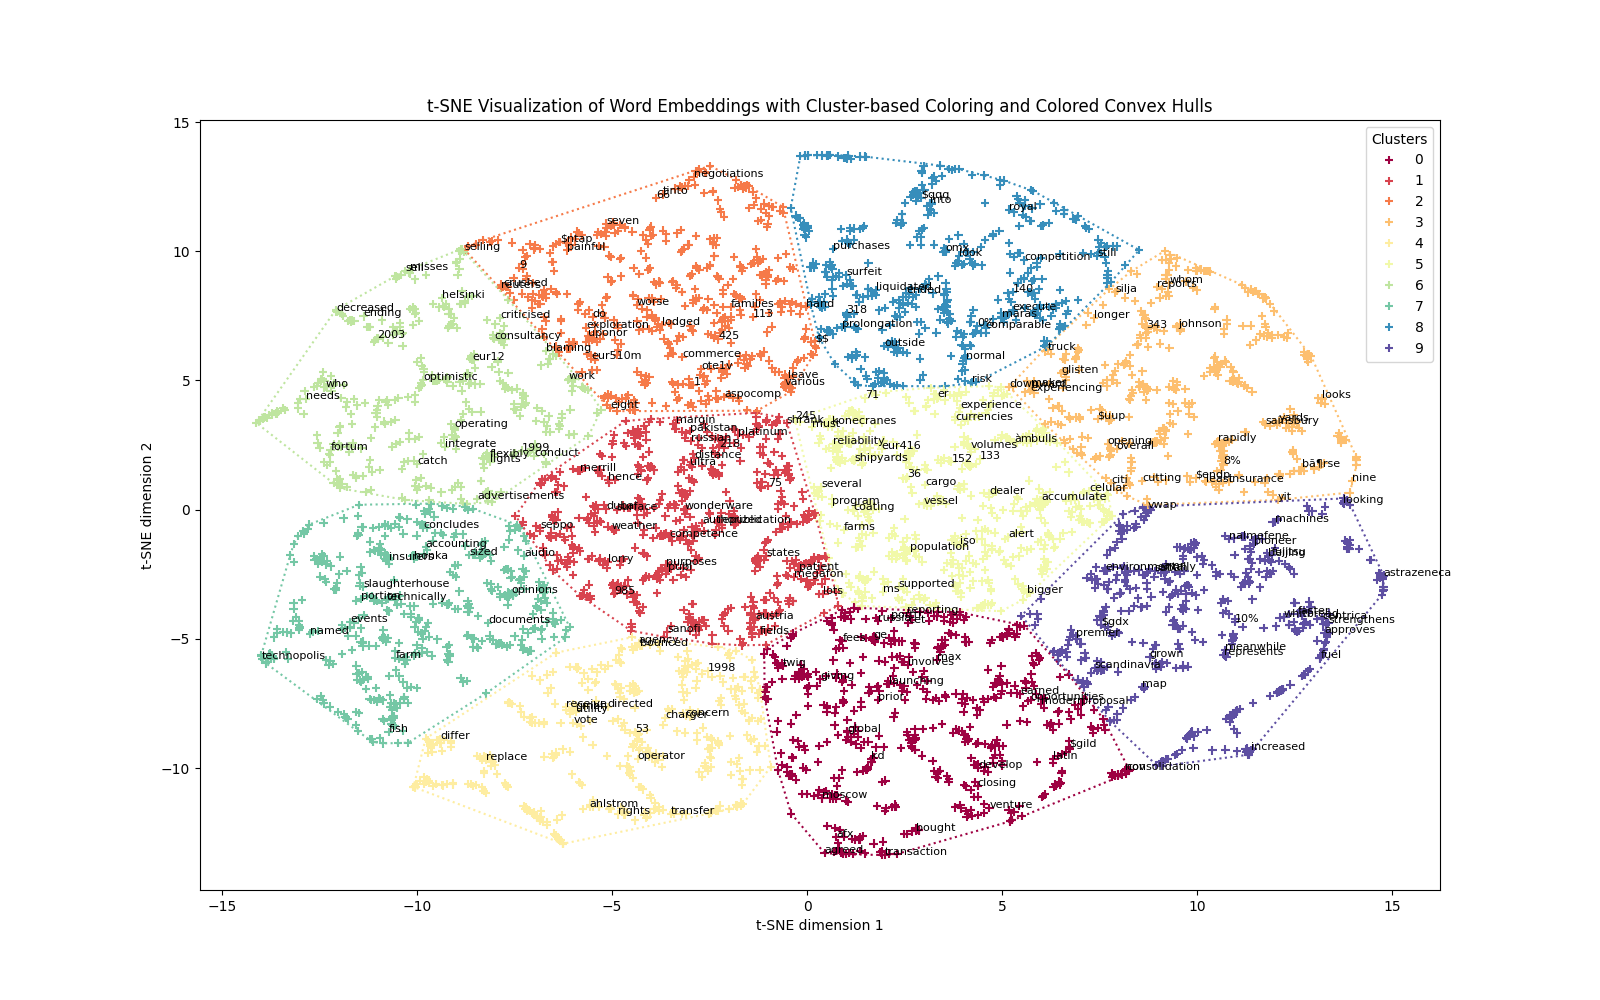

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial import ConvexHull
from matplotlib.colors import ListedColormap

# Assuming 'model' and 'tokenizer' are predefined
embeddings = model.layers[0].get_weights()[0]  # Accessing the weights of the first layer, which is the Embedding layer

# Use t-SNE to reduce the dimensionality of the embeddings
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(embeddings)

# Apply K-means clustering on the t-SNE results
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(tsne_results)

# Reverse mapping from index to word, adjusted to ensure it matches the embeddings size
num_embeddings = tsne_results.shape[0]
reverse_word_map = {index: word for word, index in tokenizer.word_index.items() if index < num_embeddings}

# Plotting with cluster-based coloring
plt.close('all')
plt.figure(figsize=(16, 10))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters, cmap='Spectral', marker="+")

# Generate a color map from the scatter plot colors
cmap = ListedColormap(scatter.cmap(scatter.norm(np.unique(clusters))))

# Annotate a subset of words to avoid clutter
for i in range(num_embeddings):  
    if i % 20 == 0:
        word = reverse_word_map.get(i)
        if word:
            safe_word = word.replace("$", "\$")
            plt.annotate(safe_word, (tsne_results[i, 0], tsne_results[i, 1]), fontsize=8)

# Draw convex hulls with colors matching their clusters
for cluster in range(kmeans.n_clusters):
    # Find the points within this cluster
    points_in_cluster = tsne_results[clusters == cluster, :]
    if points_in_cluster.shape[0] < 3:
        # Convex hulls require at least 3 points
        continue
    hull = ConvexHull(points_in_cluster)
    for simplex in hull.simplices:
        plt.plot(points_in_cluster[simplex, 0], points_in_cluster[simplex, 1], linestyle=':', color=cmap.colors[cluster])

plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.title('t-SNE Visualization of Word Embeddings with Cluster-based Coloring and Colored Convex Hulls')

# Creating a legend for clusters
plt.legend(*scatter.legend_elements(), loc="best", title="Clusters")
plt.show()



## Final remarks

In this exercise, we have undertaken the task of constructing a basic neural network using TensorFlow and Keras. The process covered essential steps including data preparation, loading, and network training. Despite the educational value of this exercise, we encountered limitations due to the small size of our dataset, which led to observable overfitting and modest accuracy levels.

These challenges emphasize the critical balance between model complexity and the scope and quality of data. Small datasets may not provide the model with sufficient information to learn generalized patterns effectively, resulting in superior performance on training data but poor generalizability to new, unseen data.

This experiment, while highlighting certain limitations, also sets the stage for future exploration. It brings to light the importance of employing strategies to mitigate overfitting, such as incorporating dropout layers, applying regularization techniques, or enhancing the dataset through augmentation. Furthermore, it invites the exploration of more advanced models, hyperparameter optimization, and the acquisition of larger and more varied datasets to improve model performance.